In [1]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error


df = pd.read_csv('zillow_data.csv.zip')

In [2]:
#here we are filtering out our zipcodes to just look at the top 500 in sizerank
df['Top500'] = df['SizeRank'].apply(lambda x: True if x <= 500 else False)

df = df.loc[df.Top500, :]

#creating growth rate metric and sorting to see top zips
df['GrowthRate'] = df['2018-04'] / df['1996-04'] - 1
df.sort_values('GrowthRate', ascending = False)[:5]

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,Top500,GrowthRate
117,62022,11211,New York,NY,New York,Kings,118,133200.0,132900.0,132500.0,...,1424700,1435300,1440500,1463100,1496100,1531100,1581900,1623700,True,11.189940
475,62027,11216,New York,NY,New York,Kings,476,146100.0,146600.0,147200.0,...,1553100,1567700,1559700,1545700,1540200,1553600,1578400,1598700,True,9.942505
191,60639,7302,Jersey City,NJ,New York,Hudson,192,137200.0,137800.0,138500.0,...,1411000,1435900,1446300,1447800,1454900,1453900,1439500,1427300,True,9.403061
106,62026,11215,New York,NY,New York,Kings,107,225700.0,227500.0,229400.0,...,2244400,2266100,2275800,2287100,2288900,2265300,2244900,2243900,True,8.941958
258,66125,20001,Washington,DC,Washington,District of Columbia,259,92000.0,92600.0,93200.0,...,771200,773300,777600,780500,781600,785500,791400,793300,True,7.622826


In [3]:
#checking which metros have the most top500 sizerank zipcodes
#we are not using houston and atlanta as they have lower growth rates than then rest
df.value_counts('Metro')[:7]

Metro
New York                          46
Los Angeles-Long Beach-Anaheim    32
Chicago                           27
Atlanta                           23
Miami-Fort Lauderdale             20
Houston                           20
Dallas-Fort Worth                 19
dtype: int64

In [4]:
#showing that almost half of zip codes in our top 500 are represented in the top 10 metros
df.value_counts('Metro')[:10].sum()

226

In [5]:
#making dfs for our Metros and checking mean growthrate
#going to use NYC, Chi, LA, MIA, and DFW highest growth rates with atleast 20 zipcodes
df_nyc = df[df['Metro'] == 'New York']
df_chi = df[df['Metro'] == 'Chicago']
df_la = df[df['Metro'] == 'Los Angeles-Long Beach-Anaheim']
df_dfw = df[df['Metro'] == 'Dallas-Fort Worth']
df_mia = df[df['Metro'] == 'Miami-Fort Lauderdale']

In [6]:
#showing growth rate in descending order
print('NYC:')
print(df_nyc['GrowthRate'].mean())
print('LA:')
print(df_la['GrowthRate'].mean())
print('MIA:')
print(df_mia['GrowthRate'].mean())
print('CHI:')
print(df_chi['GrowthRate'].mean())
print('DFW:')
print(df_dfw['GrowthRate'].mean())

NYC:
3.7712542878046262
LA:
3.2231950761389916
MIA:
1.9554887689343101
CHI:
1.3872262487454181
DFW:
0.9493054726931407


In [7]:
# function for datetimes
def get_datetimes(df):
    """
    Takes a dataframe:
    returns only those column names that can be converted into datetime objects 
    as datetime objects.
    NOTE number of returned columns may not match total number of columns in passed dataframe
    """
    
    
    return pd.to_datetime(df.columns.values[7:272], format='%Y-%m')

In [8]:
get_datetimes(df_nyc)
get_datetimes(df_la)
get_datetimes(df_mia)
get_datetimes(df_dfw)
get_datetimes(df_chi)

DatetimeIndex(['1996-04-01', '1996-05-01', '1996-06-01', '1996-07-01',
               '1996-08-01', '1996-09-01', '1996-10-01', '1996-11-01',
               '1996-12-01', '1997-01-01',
               ...
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01'],
              dtype='datetime64[ns]', length=265, freq=None)

In [9]:
#funtion for melting dataframes
def melt_data(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted = pd.melt(df, id_vars=['RegionName', 'RegionID', 'SizeRank', 'City', 'State', 'Metro', 'CountyName', 'Top500', 'GrowthRate'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

In [10]:
df_nyc = melt_data(df_nyc)
df_la = melt_data(df_la)
df_dfw = melt_data(df_dfw)
df_mia = melt_data(df_mia)
df_chi = melt_data(df_chi)

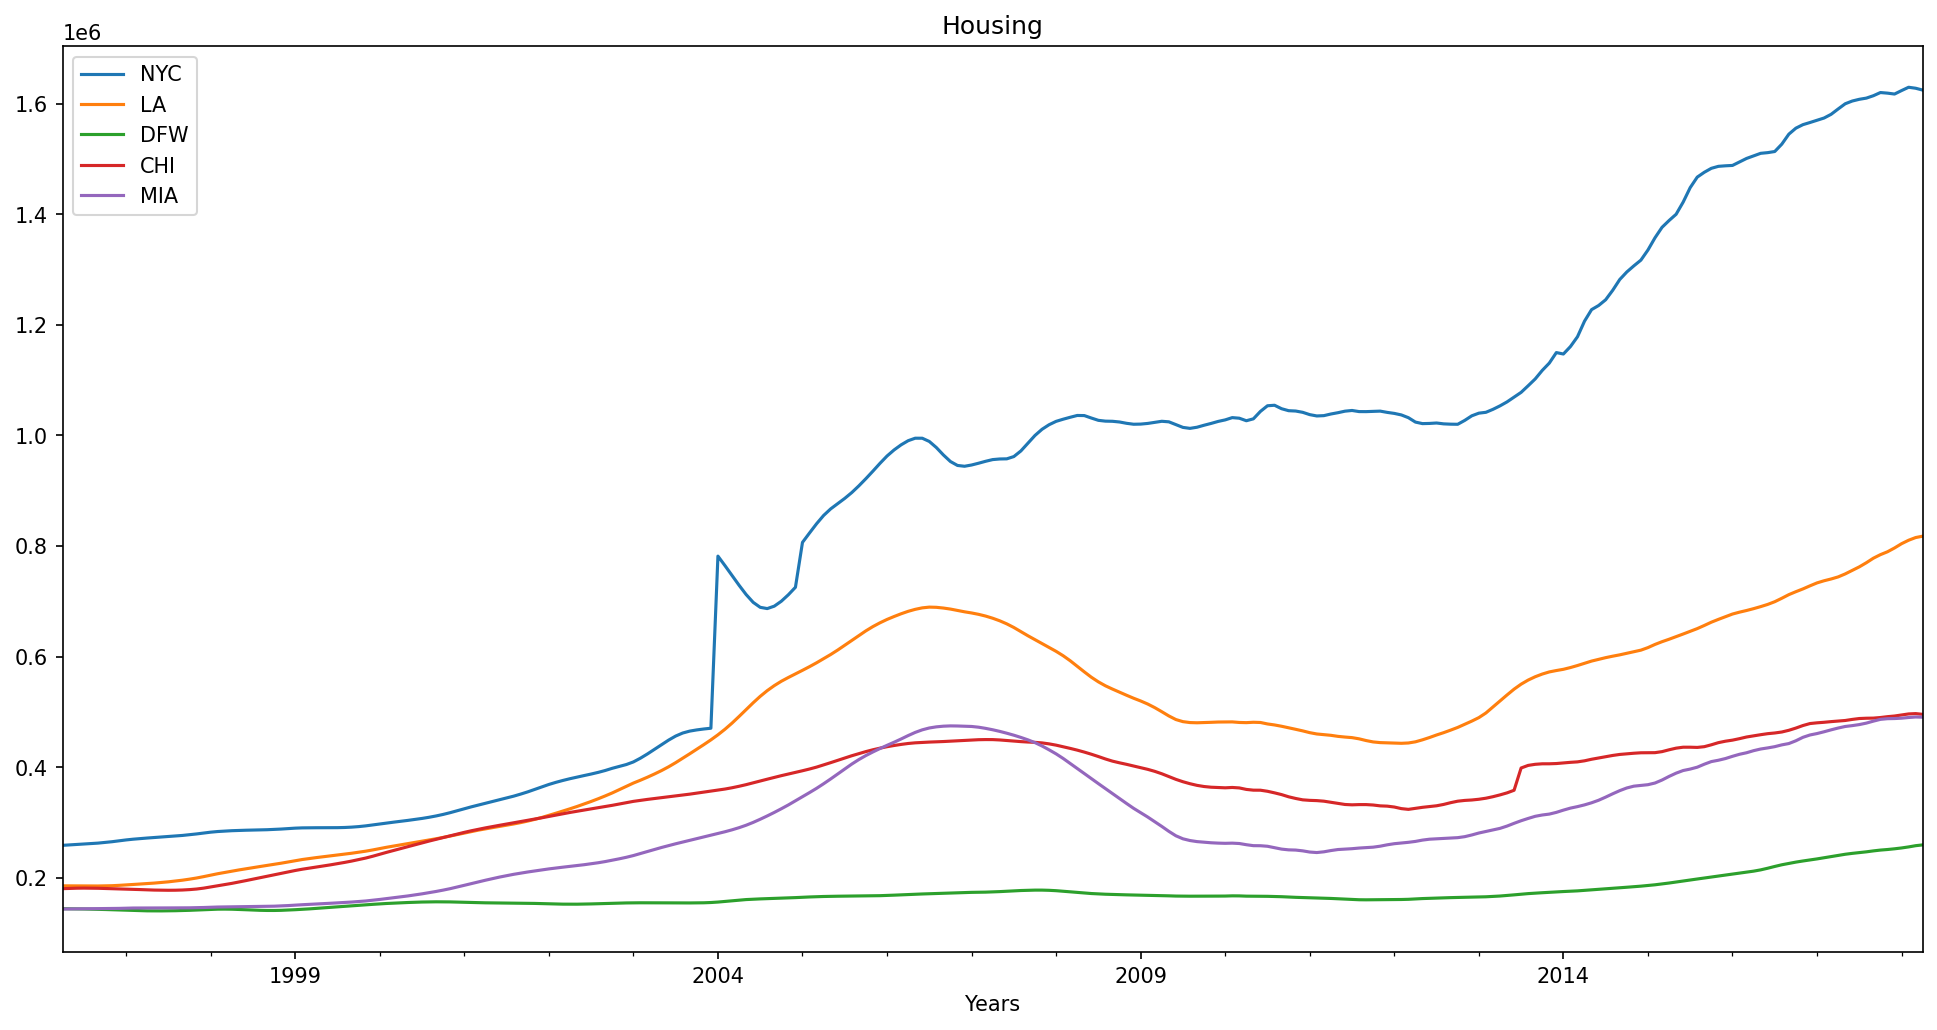

In [11]:
# Here is a plot showing all our Metros mean prices from 1996 to 2018
plt.figure(figsize=(16, 8), dpi=150)
  

df_nyc['value'].plot(label='NYC')
df_la['value'].plot(label='LA')
df_dfw['value'].plot(label='DFW')
df_chi['value'].plot(label='CHI')
df_mia['value'].plot(label='MIA')
# adding title to the plot
plt.title('Housing')
  
# adding Label to the x-axis
plt.xlabel('Years')
  
# adding legend to the curve
plt.legend();

In [12]:
#function for checking stationarity
def stationarity_check(df):

    
    # Calculate rolling statistics
    roll_mean = df.rolling(window=8, center=False).mean()
    roll_std = df.rolling(window=8, center=False).std()
    
    # Perform the Dickey Fuller Test
    dftest = adfuller(df['value'])
    
    # Plot rolling statistics:
    fig = plt.figure(figsize=(12,6))
    plt.plot(df, color='blue',label='Original')
    plt.plot(roll_mean, color='red', label='Rolling Mean')
    plt.plot(roll_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Print Dickey-Fuller test results
    print('Results of Dickey-Fuller Test: \n')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 
                                             '#Lags Used', 'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    return None

# NYC

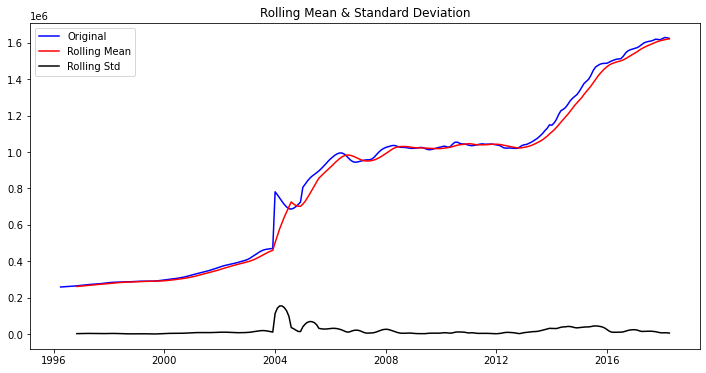

Results of Dickey-Fuller Test: 

Test Statistic                   0.531359
p-value                          0.985796
#Lags Used                       0.000000
Number of Observations Used    264.000000
Critical Value (1%)             -3.455365
Critical Value (5%)             -2.872551
Critical Value (10%)            -2.572638
dtype: float64


In [13]:
stationarity_check(df_nyc)

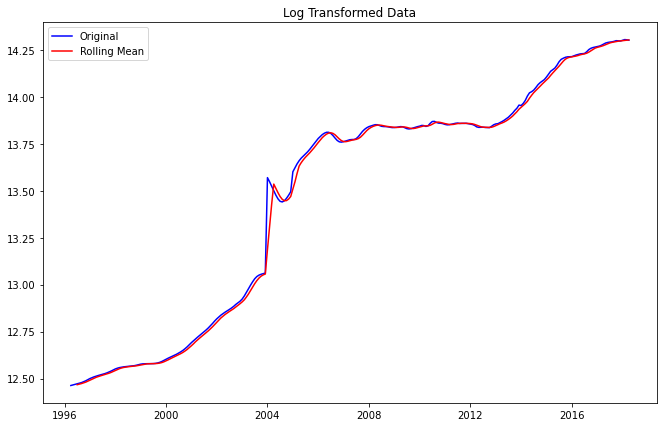

In [14]:
# lets create a log transform so we can substract the rolling mean 
roll_mean_nyc = np.log(df_nyc).rolling(window=4).mean()
fig = plt.figure(figsize=(11,7))
plt.plot(np.log(df_nyc), color='blue', label='Original')
plt.plot(roll_mean_nyc, color='red', label='Rolling Mean')
plt.legend(loc='best')
plt.title('Log Transformed Data')
plt.show(block=False)

In [15]:
# Subtract the moving average from the log transformed data
data_minus_roll_mean_nyc = np.log(df_nyc) - roll_mean_nyc

data_minus_roll_mean_nyc.dropna(inplace=True)

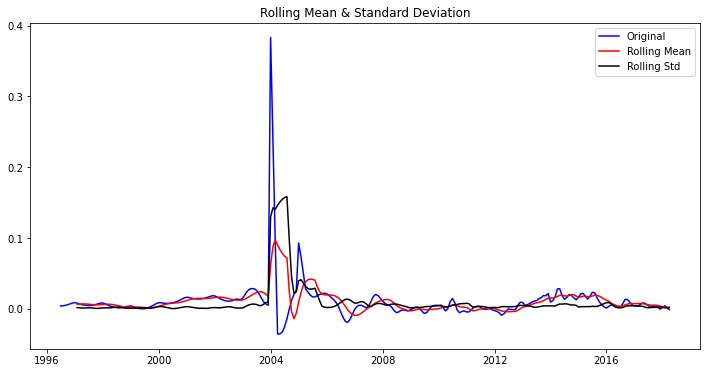

Results of Dickey-Fuller Test: 

Test Statistic                -8.699461e+00
p-value                        3.844340e-14
#Lags Used                     2.000000e+00
Number of Observations Used    2.590000e+02
Critical Value (1%)           -3.455853e+00
Critical Value (5%)           -2.872765e+00
Critical Value (10%)          -2.572752e+00
dtype: float64


In [16]:
stationarity_check(data_minus_roll_mean_nyc)
model_nyc = data_minus_roll_mean_nyc

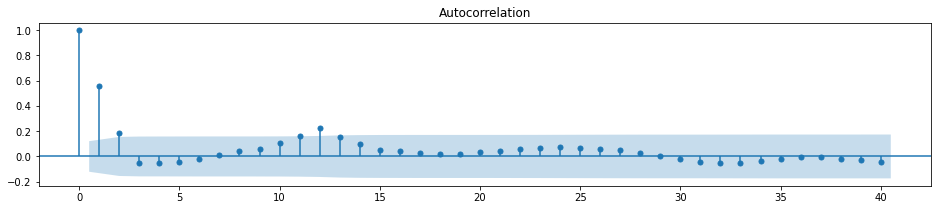

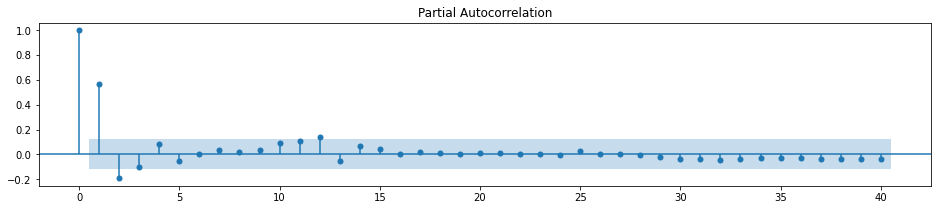

In [17]:
fig, ax = plt.subplots(figsize=(16,3))
plot_acf(model_nyc, ax=ax, lags=40);

fig, ax = plt.subplots(figsize=(16,3))
plot_pacf(model_nyc, ax=ax, lags=40);

In [18]:
train = model_nyc.iloc[:-12]
test = model_nyc.iloc[-12:]

In [19]:
arima_nyc = ARIMA(train, order=(1,0,1))

C:\Users\Clay\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Clay\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Clay\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [20]:
arima_nyc_model = arima_nyc.fit()

In [21]:
print(arima_nyc_model.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  250
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 564.335
Date:                Wed, 26 Oct 2022   AIC                          -1120.669
Time:                        12:44:35   BIC                          -1106.583
Sample:                    07-01-1996   HQIC                         -1115.000
                         - 04-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0108      0.013      0.859      0.390      -0.014       0.035
ar.L1          0.4153      0.228      1.818      0.069      -0.033       0.863
ma.L1          0.2207      0.280      0.787      0.4

In [22]:
print(arima_nyc_model.params)

const     0.010815
ar.L1     0.415261
ma.L1     0.220721
sigma2    0.000640
dtype: float64


In [23]:
y_pred = arima_nyc_model.predict(test)

TypeError: Cannot convert input [               value
time                
2017-05-01  0.008528
2017-06-01  0.006788
2017-07-01  0.004476
2017-08-01  0.002745
2017-09-01  0.003176
2017-10-01  0.004342
2017-11-01  0.001946
2017-12-01 -0.000204
2018-01-01  0.002239
2018-02-01  0.004441
2018-03-01  0.001987
2018-04-01 -0.001155] of type <class 'pandas.core.frame.DataFrame'> to Timestamp

In [ ]:
mean_squared_error(train_nyc, test_nyc)